# Recommender system

## 1. Load data from DB

In [1]:
import random
from sqlalchemy.orm import sessionmaker
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
from config.warehouse_config import get_db_engine

# Configuración de la sesión de SQLAlchemy
Session = sessionmaker(bind=get_db_engine())
session = Session()


/Users/carlos/Documents/Uni/SIO/Prac1/.venv/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## 2. Prepare the dataset

In [2]:
from model.warehouse import User, Titles, Genres, Platforms, UserPreferences, session



dataset = Dataset()

# Obtener datos de usuario y título
users = session.query(User).all()
titles = session.query(Titles).all()

all_genre_names = [genre.name for genre in session.query(Genres).all()]
all_country_codes = set(country.country_code for title in titles for country in title.countries)
all_imdb_scores = set(f"imdb_score:{title.imdb_score if title.imdb_score is not None else 'Unknown'}" for title in titles)
all_tmdb_scores = set(f"tmdb_score:{title.tmdb_score if title.tmdb_score is not None else 'Unknown'}" for title in titles)
all_types = set(f"type:{title.type if title.type is not None else 'Unknown'}" for title in titles)



In [3]:
all_preferred_types = set()
all_favorite_genres = set()
all_preferred_platforms = set()

for user in users:
    if user.preferences:
        all_preferred_types.add(user.preferences.preferred_type if user.preferences.preferred_type else 'Unknown')
        if user.preferences.favorite_genre_id:
            genre = session.get(Genres, user.preferences.favorite_genre_id)
            all_favorite_genres.add(genre.name if genre else 'Unknown')
        if user.preferences.preferred_platform_id:
            platform = session.get(Platforms, user.preferences.preferred_platform_id)
            all_preferred_platforms.add(platform.name if platform else 'Unknown')
    else:
        all_preferred_types.add('Unknown')
        all_favorite_genres.add('Unknown')
        all_preferred_platforms.add('Unknown')



In [4]:
all_item_features = (
    [f"country_code:{code}" for code in all_country_codes] +
    list(all_imdb_scores) +
    list(all_tmdb_scores) +
    list(all_types) +
    [f"genre:{genre}" for genre in all_genre_names]
)
all_item_features[:5]

['country_code:NP',
 'country_code:CO',
 'country_code:PL',
 'country_code:BY',
 'country_code:MT']

In [5]:
all_user_features = (
    [f"preferred_type:{type}" for type in all_preferred_types] +
    [f"favorite_genre:{genre}" for genre in all_favorite_genres] +
    [f"preferred_platform:{platform}" for platform in all_preferred_platforms]
)
all_user_features[:5]

['preferred_type:Unknown',
 'preferred_type:SHOW',
 'favorite_genre:reality',
 'favorite_genre:fantasy',
 'favorite_genre:Unknown']

In [6]:
# Ajustar el dataset para incluir todas las características
dataset.fit(
    users=[user.id for user in users],
    items=[title.id for title in titles],
    item_features=all_item_features,
    user_features=all_user_features
)

## 3. Build interactions

In [7]:
from model.warehouse import Platforms, UserInteractions, Genres

# Asumiendo que la sesión de SQLAlchemy ya está configurada y los modelos importados
session = Session()

# Carga de datos necesarios
users = session.query(User).all()
titles = session.query(Titles).all()
genres = session.query(Genres).all()

# Construcción de interacciones
interactions, weights = dataset.build_interactions(
    ((interaction.user_id, interaction.title_id, interaction.rating)
     for interaction in session.query(UserInteractions).all())
)

# Construcción de características de ítems
item_features = dataset.build_item_features(
    (title.id, [
        f"country_code:{country.country_code}" for country in title.countries
    ] + [
        f"imdb_score:{title.imdb_score if title.imdb_score is not None else 'Unknown'}",
        f"tmdb_score:{title.tmdb_score if title.tmdb_score is not None else 'Unknown'}",
        f"type:{title.type if title.type is not None else 'Unknown'}"
    ] + [f"genre:{genre.name}" for genre in title.genres]) for title in titles
)

# Construcción de características de usuarios
user_features = dataset.build_user_features(
    (user.id, [
        f"preferred_type:{user.preferences.preferred_type if user.preferences and user.preferences.preferred_type else 'Unknown'}" if user.preferences else 'preferred_type:Unknown',
        f"favorite_genre:{session.get(Genres, user.preferences.favorite_genre_id).name if user.preferences and user.preferences.favorite_genre_id else 'Unknown'}" if user.preferences and user.preferences.favorite_genre_id else 'favorite_genre:Unknown',
        f"preferred_platform:{session.get(Platforms, user.preferences.preferred_platform_id).name if user.preferences and user.preferences.preferred_platform_id else 'Unknown'}" if user.preferences and user.preferences.preferred_platform_id else 'preferred_platform:Unknown'
    ]) for user in users
)


## 4. Train model

0 interacciones han sido generadas e insertadas.
0 interacciones han sido eliminadas.
10 interacciones han sido generadas e insertadas.
10 interacciones han sido eliminadas.
20 interacciones han sido generadas e insertadas.
20 interacciones han sido eliminadas.
50 interacciones han sido generadas e insertadas.
50 interacciones han sido eliminadas.
100 interacciones han sido generadas e insertadas.
100 interacciones han sido eliminadas.
200 interacciones han sido generadas e insertadas.
200 interacciones han sido eliminadas.
500 interacciones han sido generadas e insertadas.
500 interacciones han sido eliminadas.
1000 interacciones han sido generadas e insertadas.
1000 interacciones han sido eliminadas.
10000 interacciones han sido generadas e insertadas.
10000 interacciones han sido eliminadas.


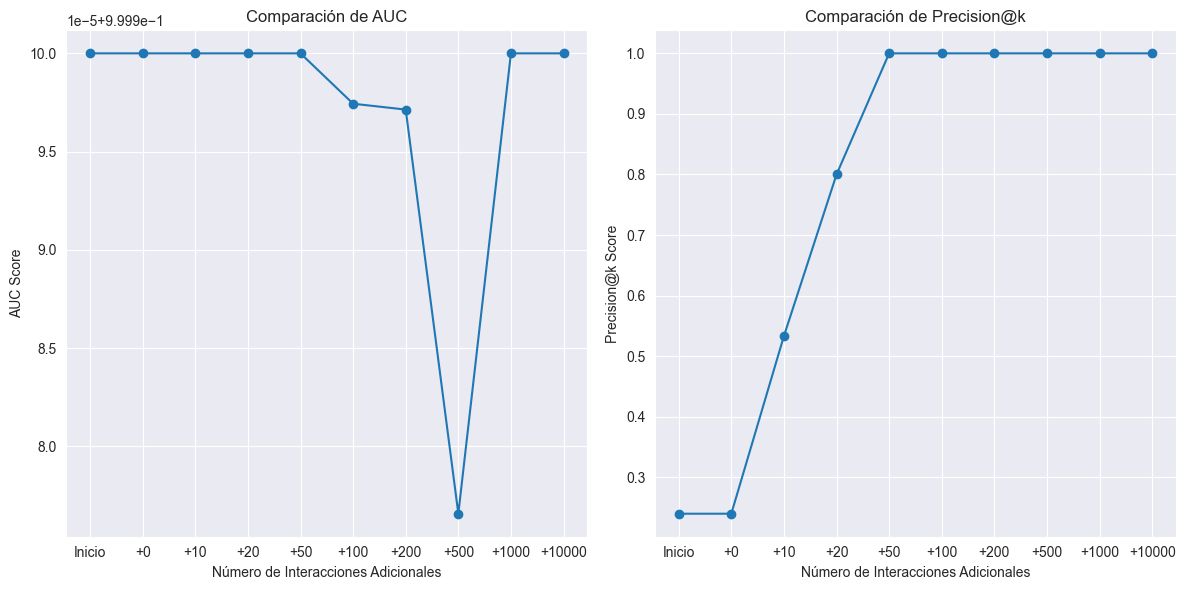

In [8]:
from recommenderUtils import train_model

model = train_model(interactions, item_features, user_features)

## 5. Evaluate model

Podemos comprobar que cuantos más datos tenemos, más precisa es la predicción del algoritmo, no obstante habría que hacer crowdsourcing para evaluar la calidad de las recomendaciones y poder tener datos basados en el gusto real de los usuarios.

In [10]:
from recommenderUtils import evaluate_model

train_auc,train_precision = evaluate_model(model, interactions, item_features, user_features)
print(f'Train Precision: {train_precision}')
print(f'Train AUC: {train_auc}')

Train Precision: 0.07999999821186066
Train AUC: 0.9835641980171204


## 5.1 Add more rows to the dataset